In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import sys
from PIL import Image

In [7]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, GRU, CuDNNGRU, Embedding
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [5]:
import coco

from coco import cache

In [6]:
coco.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.
Data has apparently already been downloaded and unpacked.
- Download progress: 3.4%

In [8]:
_, filenames, captions = coco.load_records(train=True)

In [13]:
num_images = len(filenames)
num_images

In [10]:
def load_image(path, size=None):
    img = Image.open(path)
    
    if not size is None:
        img = img.resize(size=size, resample=Image.LANCZOS)
        
    return img

In [11]:
def show_image(idx):
    dir = coco.train_dir
    filename = filenames[idx]
    caption = captions[idx]
    
    path = os.path.join(dir, filename)
    
    for cap in caption:
        print(cap)
        
    img = load_image(path)
    plt.imshow(img)
    plt.show()

In [12]:
show_image(idx=1)

In [10]:
image_model = VGG16()

In [11]:
image_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [12]:
transfer_layer = image_model.get_layer('fc2')

In [13]:
image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

In [14]:
img_size = K.int_shape(image_model.input)[1:3]
img_size

(224, 224)

In [15]:
transfer_values_size = K.int_shape(transfer_layer.output)[1]
transfer_values_size

4096

In [16]:
def print_progress(count, max_count):
    pct_complete = count / max_count
    
    msg = '\r- Progress: {0:.1%}'.format(pct_complete)
    
    sys.stdout.write(msg)
    sys.stdout.flush()

In [17]:
def process_images(data_dir, filenames, batch_size=32):
    num_images = len(filenames)
    
    shape = (batch_size,) + img_size + (3,)
    image_batch = np.zeros(shape=shape, dtype=np.float16)
    
    start_index = 0
    
    while start_index < num_images:
        print_progress(count=start_index, max_count=num_images)
        end_index = start_index + batch_size
        
        if end_index > num_images:
            end_index = num_images
        
        current_batch_size = end_index - start_index
        
        for i, filename in enumerate(filenames[start_index:end_index]):
            path = os.path.join(data_dir, filename)
            img = load_image(path, size=img_size)
            image_batch[i] = img
            
        transfer_values_batch = image_model_transfer.predict(image_batch[0:current_batch_size])
        transfer_values[start_index:end_index] = transfer_values_batch[0:current_batch_size]
        
        start_index = end_index
        
    print()
    return transfer_values

In [18]:
def process_train_images():
    print('Eğitim setindeki {0} resim işleniyor...'.format(len(filenames)))
    
    cache_path = os.path.join(coco.data_dir, 'transfer_values_train.pkl')
    
    transfer_values = cache(cache_path=cache_path,
                            fn=process_images,
                            data_dir=coco.train_dir,
                            filenames=filenames)
    
    return transfer_values

In [19]:
%%time
transfer_values = process_train_images()
print('Shape:', transfer_values.shape)

Eğitim setindeki 118287 resim işleniyor...
- Data loaded from cache-file: data/coco/transfer_values_train.pkl
Shape: (118287, 4096)
Wall time: 1.21 s


In [20]:
mark_start = 'ssss '
mark_end = ' eeee'

In [21]:
def mark_captions(captions_listlist):
    captions_marked = [[mark_start + caption + mark_end
                        for caption in captions_list]
                        for captions_list in captions_listlist]
    return captions_marked

In [22]:
captions_marked = mark_captions(captions)

In [23]:
captions_marked[1]

['ssss A giraffe eating food from the top of the tree. eeee',
 'ssss A giraffe standing up nearby a tree  eeee',
 'ssss A giraffe mother with its baby in the forest. eeee',
 'ssss Two giraffes standing in a tree filled area. eeee',
 'ssss A giraffe standing next to a forest filled with trees. eeee']

In [24]:
captions[1]

['A giraffe eating food from the top of the tree.',
 'A giraffe standing up nearby a tree ',
 'A giraffe mother with its baby in the forest.',
 'Two giraffes standing in a tree filled area.',
 'A giraffe standing next to a forest filled with trees.']

In [25]:
def flatten(captions_listlist):
    captions_list = [caption
                     for captions_list in captions_listlist
                     for caption in captions_list]
    return captions_list

In [26]:
captions_flat = flatten(captions_marked)

In [27]:
num_words = 10000

In [28]:
class TokenizerWrap(Tokenizer): # CP captions_to_tokens'i kopyalama, yazılacak
    
    def __init__(self, texts, num_words=None):
        Tokenizer.__init__(self, num_words=num_words)
        
        self.fit_on_texts(texts)

        self.index_to_word = dict(zip(self.word_index.values(),
                                      self.word_index.keys()))

    def token_to_word(self, token):
        word = " " if token == 0 else self.index_to_word[token]
        return word 

    def tokens_to_string(self, tokens):
        words = [self.index_to_word[token] for token in tokens if token != 0]
        
        text = " ".join(words)

        return text
    
    def captions_to_tokens(self, captions_listlist):
        tokens = [self.texts_to_sequences(captions_list)
                  for captions_list in captions_listlist]
        return tokens

In [29]:
tokenizer = TokenizerWrap(texts=captions_flat, num_words=num_words)

In [30]:
tokens_train = tokenizer.captions_to_tokens(captions_marked)

In [31]:
tokens_train[1]

[[2, 1, 118, 108, 61, 96, 6, 32, 5, 6, 132, 3],
 [2, 1, 118, 17, 34, 681, 1, 132, 3],
 [2, 1, 118, 762, 8, 152, 206, 7, 6, 432, 3],
 [2, 15, 203, 17, 7, 1, 132, 143, 101, 3],
 [2, 1, 118, 17, 20, 12, 1, 432, 143, 8, 130, 3]]

In [32]:
captions_marked[1]

['ssss A giraffe eating food from the top of the tree. eeee',
 'ssss A giraffe standing up nearby a tree  eeee',
 'ssss A giraffe mother with its baby in the forest. eeee',
 'ssss Two giraffes standing in a tree filled area. eeee',
 'ssss A giraffe standing next to a forest filled with trees. eeee']

In [33]:
token_start = tokenizer.word_index[mark_start.strip()]

In [34]:
token_end = tokenizer.word_index[mark_end.strip()]

In [35]:
def get_random_caption_tokens(idx):
    result = []
    
    for i in idx:
        j = np.random.choice(len(tokens_train[i]))
        tokens = tokens_train[i][j]
        result.append(tokens)
    
    return result

In [36]:
def batch_generator(bathc_size):
    while True:
        idx = np.random.randint(num_images, size=batch_size)
        
        t_values = transfer_values[idx]
        tokens = get_random_caption_tokens(idx)
        
        num_tokens = [len(t) for t in tokens]
        max_tokens = np.max(num_tokens)
        
        tokens_padded = pad_sequences(tokens,
                                      maxlen=max_tokens,
                                      padding='post',
                                      truncating='post')
        
        decoder_input_data = tokens_padded[:, 0:-1]
        decoder_output_data = tokens_padded[:, 1:]
        
        x_data = {'decoder_input': decoder_input_data, 'transfer_values_input': t_values}
        y_data = {'decoder_output': decoder_output_data}
        
        yield (x_data, y_data)

In [37]:
batch_size = 256

In [38]:
generator = batch_generator(batch_size)

In [39]:
batch = next(generator)
batch_x = batch[0]
batch_y = batch[1]

In [40]:
batch_x['transfer_values_input'][0]

array([0.   , 0.   , 1.214, ..., 0.   , 0.   , 0.826], dtype=float16)

In [41]:
batch_x['decoder_input'][0]

array([   2,    1,  134,   12,  134, 2807, 1854,   44,    8, 4427,  670,
          9,   70, 1107,    3,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0])

In [42]:
batch_y['decoder_output'][0]

array([   1,  134,   12,  134, 2807, 1854,   44,    8, 4427,  670,    9,
         70, 1107,    3,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0])

In [43]:
num_captions = [len(caption) for caption in captions]

In [44]:
total_num_captions = np.sum(num_captions)

In [45]:
total_num_captions

591753

In [46]:
steps_per_epoch = int(total_num_captions / batch_size)

In [47]:
steps_per_epoch

2311

In [48]:
state_size = 256

In [49]:
embedding_size = 100

In [50]:
transfer_values_input = Input(shape=(transfer_values_size,),
                              name='transfer_values_input')

In [51]:
decoder_transfer_map = Dense(state_size,
                             activation='tanh',
                             name='decoder_transfer_map')

In [52]:
decoder_input = Input(shape=(None,), name='decoder_input')

In [53]:
word2vec = {} 
with open('glove.6B.100d.txt', encoding='UTF-8') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec

In [54]:
embedding_matrix = np.random.uniform(-1, 1, (num_words, embedding_size)) 
for word, i in tokenizer.word_index.items():
    if i < num_words:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [55]:
decoder_embedding = Embedding(input_dim=num_words, 
                              output_dim=embedding_size,
                              weights=[embedding_matrix],
                              trainable=False,
                              name='decoder_embedding')

In [56]:
decoder_gru1 = GRU(state_size, name='decoder_gru1', return_sequences=True)
decoder_gru2 = GRU(state_size, name='decoder_gru2', return_sequences=True)
decoder_gru3 = GRU(state_size, name='decoder_gru3', return_sequences=True)

In [57]:
decoder_dense = Dense(num_words,
                      activation='linear',
                      name='decoder_output')

In [58]:
def connect_decoder(transfer_values):
    initial_state = decoder_transfer_map(transfer_values)

    net = decoder_input
    net = decoder_embedding(net)
    net = decoder_gru1(net, initial_state=initial_state)
    net = decoder_gru2(net, initial_state=initial_state)
    net = decoder_gru3(net, initial_state=initial_state)
    decoder_output = decoder_dense(net)
    
    return decoder_output

In [59]:
decoder_output = connect_decoder(transfer_values=transfer_values_input)

decoder_model = Model(inputs=[transfer_values_input, decoder_input],
                      outputs=[decoder_output])

In [60]:
def sparse_cross_entropy(y_true, y_pred):
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true,
                                                          logits=y_pred)

    loss_mean = tf.reduce_mean(loss)

    return loss_mean

In [61]:
optimizer = RMSprop(lr=1e-3)

In [62]:
decoder_target = tf.placeholder(dtype='int32', shape=(None, None))

In [63]:
decoder_model.compile(optimizer=optimizer,
                      loss=sparse_cross_entropy,
                      target_tensors=[decoder_target])

In [64]:
path_checkpoint = 'checkpoint.keras'
checkpoint = ModelCheckpoint(filepath=path_checkpoint, save_weights_only=True)

In [65]:
try:
    decoder_model.load_weights(path_checkpoint)
except Exception as error:
    print("Checkpoint yüklenirken hata oluştu. Eğitime sıfırdan başlanıyor.")
    print(error)

In [66]:
decoder_model.fit_generator(generator=generator,
                            steps_per_epoch=steps_per_epoch,
                            epochs=20,
                            callbacks=[checkpoint])

In [67]:
def generate_caption(image_path, max_tokens=30):
    image = load_image(image_path, size=img_size)
    
    image_batch = np.expand_dims(image, axis=0)
    
    transfer_values = image_model_transfer.predict(image_batch)
    
    decoder_input_data = np.zeros(shape=(1, max_tokens), dtype=np.int)

    token_int = token_start
    output_text = ''
    count_tokens = 0

    while token_int != token_end and count_tokens < max_tokens:
        decoder_input_data[0, count_tokens] = token_int

        x_data = {'transfer_values_input': transfer_values, 'decoder_input': decoder_input_data}

        decoder_output = decoder_model.predict(x_data)

        token_onehot = decoder_output[0, count_tokens, :]
        token_int = np.argmax(token_onehot)

        sampled_word = tokenizer.token_to_word(token_int)
        output_text += " " + sampled_word
        count_tokens += 1
        
    plt.imshow(image)
    plt.show()
    
    print('Predicted caption:')
    print(output_text)
    print()

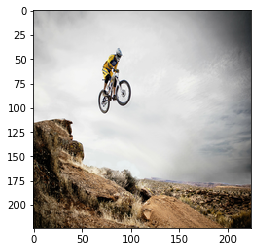

Predicted caption:
 a man riding a wave on top of a surfboard eeee



In [70]:
generate_caption('images/3.jpg')

In [71]:
def generate_caption_coco(idx):
    data_dir = coco.train_dir
    filename = filenames[idx]
    caption = captions[idx]
    
    path = os.path.join(data_dir, filename)
    
    generate_caption(image_path=path)
    
    print('True captions:')
    for cap in caption:
        print(cap)

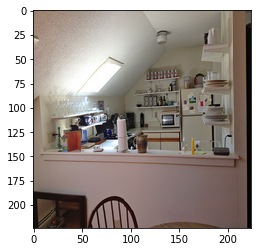

Predicted caption:
 a kitchen with a stove and a refrigerator eeee

True captions:
A small kitchen with low a ceiling 
A small kichen area with a sunlight and and angled ceiling.
an image of a kitchen loft style setting
a small kitchen with a lot of filled up shelves 
A kitchen with a slanted ceiling and skylight.


In [74]:
generate_caption_coco(idx=33)